# Statistical Comparisons: Quantisation and Metrics

This notebook evaluates the statistical effects of mantissa bit reduction (quantisation) on floating-point physics variables. It computes divergences, classifier metrics, and visualizes the impact of quantisation on data distributions.

## 1. Import Libraries and Define Helper Functions

Import required libraries and define functions for quantisation, summary statistics, and statistical metrics.

In [28]:
import numpy as np
import ctypes
import scipy.stats as stats
from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datagen import get_dataloader, create_file_pairs

# -------- Helper Functions --------

def reduce_float_precision(value, nmantissa):
    # Constants
    NMANTISSA = 23
    MAX_EXPONENT = 0x7f7  # corresponds to max exponent before Inf (254 in biased form)
    MIN_MANTISSA_BITS = 1

    # Convert float32 to raw bits
    float_val = ctypes.c_float(value)
    bits = ctypes.cast(ctypes.pointer(float_val), ctypes.POINTER(ctypes.c_uint32)).contents.value

    # Handle NaN and Inf (do not compress)
    if (bits & 0x7f800000) == 0x7f800000:
        return value  # Already Inf/NaN

    # If full mantissa requested, or invalid range, return original
    if nmantissa >= NMANTISSA or nmantissa <= 0:
        return value

    # Clamp to minimum mantissa
    if nmantissa < MIN_MANTISSA_BITS:
        nmantissa = MIN_MANTISSA_BITS

    # Compute shift and masks
    shift = NMANTISSA - nmantissa
    mask = (~0) << shift  # Keeps upper nmantissa bits
    round_bit = 1 << (shift - 1)

    mantissa = bits & 0x007fffff
    exponent = (bits >> 23) & 0xff

    # Create a mask for vmax check (from C++)
    vmax = (MAX_EXPONENT << 23) | (0x007fffff ^ round_bit)

    # Perform rounding if it won't cause overflow
    if (bits & 0x7fffffff) < vmax:
        mantissa += round_bit

    # Apply mantissa mask (truncate lower bits)
    mantissa &= mask

    # Reassemble final bits
    compressed_bits = (bits & 0xff800000) | mantissa  # keep sign and exponent

    # Convert bits back to float32
    compressed_uint = ctypes.c_uint32(compressed_bits)
    compressed_float = ctypes.cast(ctypes.pointer(compressed_uint), ctypes.POINTER(ctypes.c_float)).contents.value

    return compressed_float

def float_to_bits(val):
    """Convert a float32 to its raw 32-bit representation."""
    float_val = ctypes.c_float(val)
    bits = ctypes.cast(ctypes.pointer(float_val), ctypes.POINTER(ctypes.c_uint32)).contents.value
    return bits

def print_float_bits(val, label="Value"):
    bits = float_to_bits(val)
    sign = (bits >> 31) & 0x1
    exponent = (bits >> 23) & 0xff
    mantissa = bits & 0x7fffff
    return f"{label}: {val:.6f} | Sign: {sign} Exponent: {exponent:08b} Mantissa: {mantissa:023b}"


def summary_stats(x):
    return {
        "mean": np.mean(x),
        "std": np.std(x),
        "skew": stats.skew(x),
        "kurtosis": stats.kurtosis(x),
    }

def kl_divergence(p, q, bins=100):
    """KL divergence between histograms p and q"""
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    p_hist += 1e-10; q_hist += 1e-10  # avoid div by zero
    return stats.entropy(p_hist, q_hist)

def js_divergence(p, q, bins=100):
    """Jensen-Shannon divergence"""
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    m = 0.5 * (p_hist + q_hist)
    return 0.5 * (stats.entropy(p_hist, m) + stats.entropy(q_hist, m))

def mmd_rbf(x, y, gamma=1.0):
    """Maximum Mean Discrepancy with RBF kernel"""

    def kernel(a, b):
        sq_dists = np.sum(a**2, 1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        sq_dists = np.maximum(sq_dists, 0)  # clamp negatives from precision errors
        K = np.exp(-gamma * np.clip(sq_dists, 0, 1e6))  # prevent overflow
        return K
    
    
    x = x[:min(5000, len(x))].reshape(-1,1)
    y = y[:min(5000, len(y))].reshape(-1,1)
    Kxx = kernel(x, x).mean()
    Kyy = kernel(y, y).mean()
    Kxy = kernel(x, y).mean()
    return Kxx + Kyy - 2*Kxy

def classifier_test(x, y):
    """Train/test classifier to detect original vs compressed"""
    X = np.concatenate([x.reshape(-1,1), y.reshape(-1,1)])
    labels = np.array([0]*len(x) + [1]*len(y))
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, stratify=labels)
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_score)
    return auc

# -------- Main Triage Pipeline --------

def triage(original, compressed, name="Condition"):
    """Compute summary statistics, divergences, and classifier metrics between original and compressed arrays."""
    results = {"name": name}

    # Step 0: Bits representation for first 3 values (optional debug)
    bits_info = []
    for i in range(min(3, len(original))):
        orig_bits = print_float_bits(original[i])
        comp_bits = print_float_bits(compressed[i])
        bits_info.append({
            "index": i,
            "original_value": original[i],
            "original_bits": orig_bits,
            "compressed_value": compressed[i],
            "compressed_bits": comp_bits
        })
    results["bits_info"] = bits_info

    # Step 1: Summary statistics
    results["summary_original"] = summary_stats(original)
    results["summary_compressed"] = summary_stats(compressed)

    # Step 2: Divergences
    results["kl_divergence"] = kl_divergence(original, compressed)
    results["js_divergence"] = js_divergence(original, compressed)
    results["wasserstein"] = wasserstein_distance(original, compressed)
    results["mmd"] = mmd_rbf(original, compressed)

    # Step 3: Hypothesis tests
    ks_stat, ks_p = stats.ks_2samp(original, compressed)
    results["ks_stat"] = ks_stat
    results["ks_p"] = ks_p

    # Step 4: Classifier
    results["classifier_auc"] = classifier_test(original, compressed)

    return results


## 2. Data Loading

Load electron $p_T$ data using the dataloader utility and set up the analysis range.

In [29]:
branch = "AnalysisElectronsAuxDyn"
varnames = ["pt"]
global_min=712
global_max=716800
dataloader = get_dataloader(branch=branch, varnames=varnames, hist=False, range=(global_min, global_max), full_sample_mode=True, batch_size=1, shuffle=False)

## 3. Quantisation and Metric Computation

Apply mantissa bit reduction to the data and compute statistical metrics for each quantisation level.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

mantissa_list = [2, 3, 5, 10, 15]
metrics_all = []

for compressed, residual in dataloader:
    compressed = compressed.squeeze()
    residual = residual.squeeze()
    original = compressed + residual

    for nmantissa in mantissa_list:
        compressed_new = np.array([reduce_float_precision(i, nmantissa=nmantissa) for i in original])
        metrics = triage(original.numpy(), compressed_new, name=f"nmantissa={nmantissa}")
        metrics["nmantissa"] = nmantissa
        metrics_all.append(metrics)


/home/kanbina/code/dct_flow/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


## 4. Results Aggregation

Aggregate computed metrics into a DataFrame for visualization.

In [31]:
import pandas as pd

# Flatten results for plotting
records = []
for m in metrics_all:
    record = {
        "nmantissa": m["nmantissa"],
        "KL": m["kl_divergence"],
        "JS": m["js_divergence"],
        "Wasserstein": m["wasserstein"],
        "MMD": m["mmd"],
        "KS": m["ks_stat"],
        "AUC": m["classifier_auc"]
    }
    records.append(record)

df_metrics = pd.DataFrame(records)


## 5. Visualization of Metric Trends

Plot the trends of KL, JS, Wasserstein, MMD, KS, and classifier AUC as a function of mantissa bits.

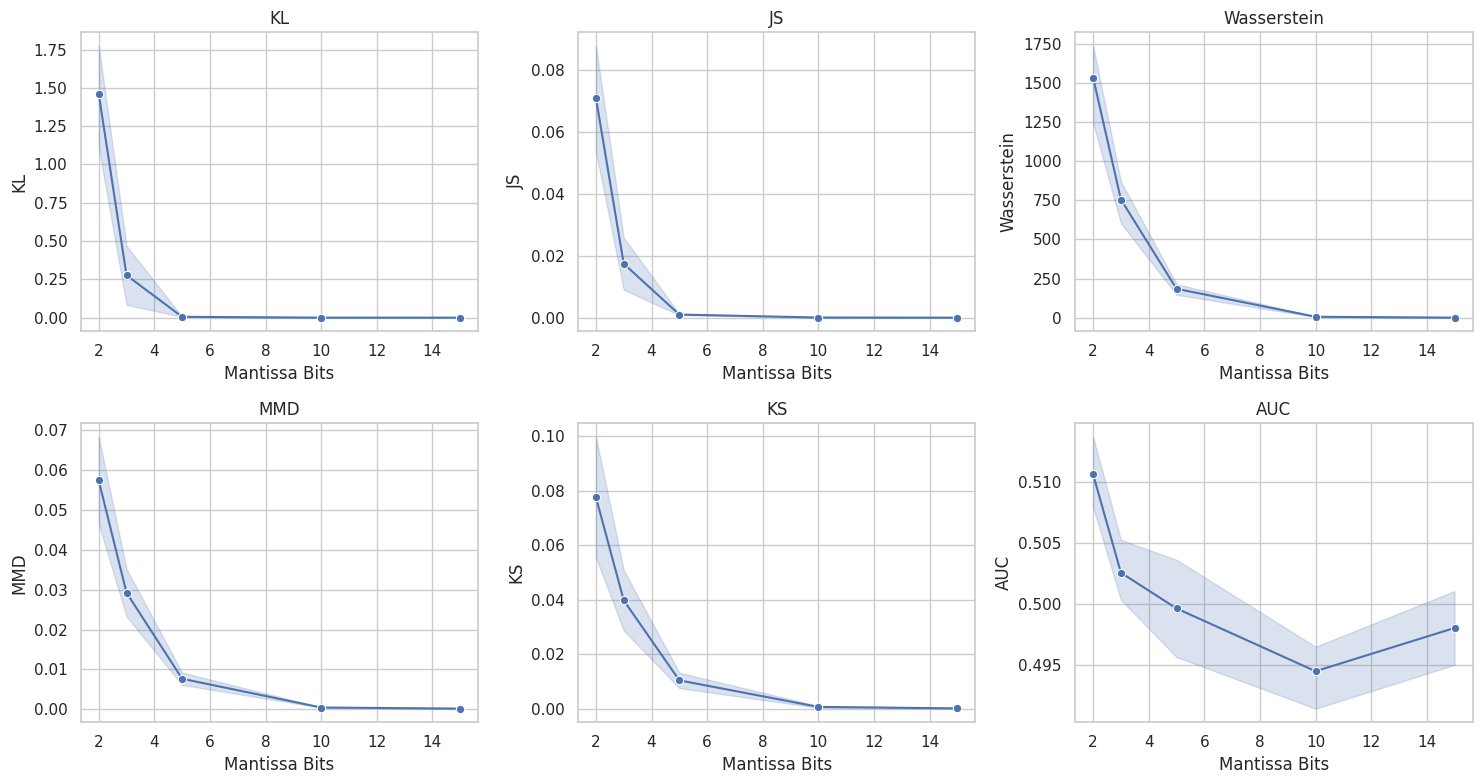

In [32]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(["KL", "JS", "Wasserstein", "MMD", "KS", "AUC"]):
    sns.lineplot(data=df_metrics, x="nmantissa", y=col, marker="o", ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("Mantissa Bits")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()
